In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns


## Load capacity-example file

In [2]:
file_path_planet = '../suyana/drought/capacity_example/processed/'

In [3]:
names_files = sorted(os.listdir(file_path_planet))

filtered_files = [file for file in names_files if "capacity_example" in file]

print(filtered_files)

['capacity_example_2002-2011.nc', 'capacity_example_2002-2024.nc', 'capacity_example_2012-2024.nc']


In [4]:
for i in range(len(filtered_files)):
    ifile = filtered_files[i]
    print(ifile)
    ds = xr.open_dataset(file_path_planet + ifile)
    print(ds.coords)
    ds.close()

capacity_example_2002-2011.nc
Coordinates:
  * lon      (lon) float64 248B -62.04 -62.03 -62.02 ... -61.79 -61.78 -61.77
  * lat      (lat) float64 352B -17.36 -17.36 -17.37 ... -17.73 -17.73 -17.74
  * time     (time) datetime64[ns] 27kB 2002-06-15 2002-06-16 ... 2011-10-03
capacity_example_2002-2024.nc
Coordinates:
  * time     (time) datetime64[ns] 65kB 2002-06-15 2002-06-16 ... 2024-10-31
capacity_example_2012-2024.nc
Coordinates:
  * lon      (lon) float64 248B -62.04 -62.03 -62.02 ... -61.79 -61.78 -61.77
  * lat      (lat) float64 352B -17.36 -17.36 -17.37 ... -17.73 -17.73 -17.74
  * time     (time) datetime64[ns] 36kB 2012-07-25 2012-07-26 ... 2024-11-04


In [5]:
## lets use this one as an example

ifile = filtered_files[0]
print(ifile)


capacity_example_2002-2011.nc


## load era5 file

In [6]:
file_path_era5 = './data/'

In [7]:
ds_planet = xr.open_dataset(file_path_planet + ifile)


In [8]:
ds_era5 = xr.open_dataset(file_path_era5 + 'merged_data_1990_2024_daily_means.nc')
ds_era5.coords

Coordinates:
  * longitude  (longitude) float32 164B -64.0 -63.9 -63.8 ... -60.2 -60.1 -60.0
  * latitude   (latitude) float32 164B -15.0 -15.1 -15.2 ... -18.8 -18.9 -19.0
  * time       (time) datetime64[ns] 101kB 1990-01-01 1990-01-02 ... 2024-08-18

## Comparison

### 1. mean variables 

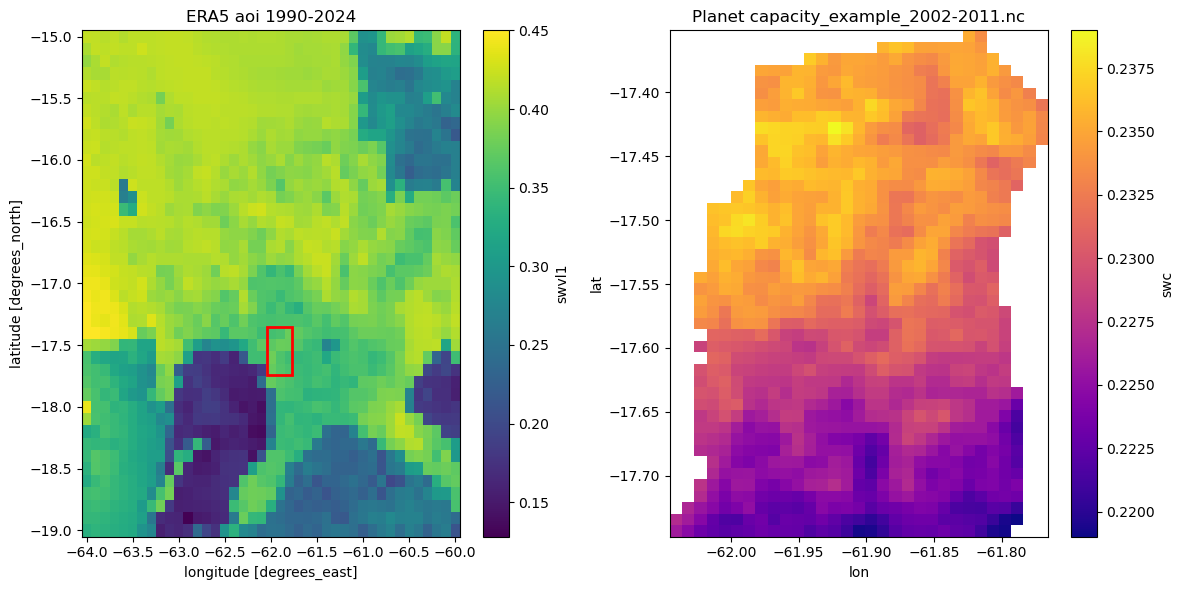

In [9]:
# compute and show mean variables to get the overview

var1 = ds_era5['swvl1']
var2 = ds_planet['swc']

lon_min, lon_max = ds_planet.lon.min().item(), ds_planet.lon.max().item()
lat_min, lat_max = ds_planet.lat.min().item(), ds_planet.lat.max().item()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

var1.mean(dim='time').plot(ax=axes[0], cmap='viridis')
axes[0].set_title("ERA5 aoi 1990-2024")

rect = Rectangle((lon_min, lat_min),  # esq inferior izquierda
                 lon_max - lon_min,  # width
                 lat_max - lat_min,  # height
                 linewidth=2, edgecolor='red', facecolor='none')
axes[0].add_patch(rect)

var2.mean(dim='time').plot(ax=axes[1], cmap='plasma')
axes[1].set_title("Planet " + ifile)

plt.tight_layout()
plt.show()


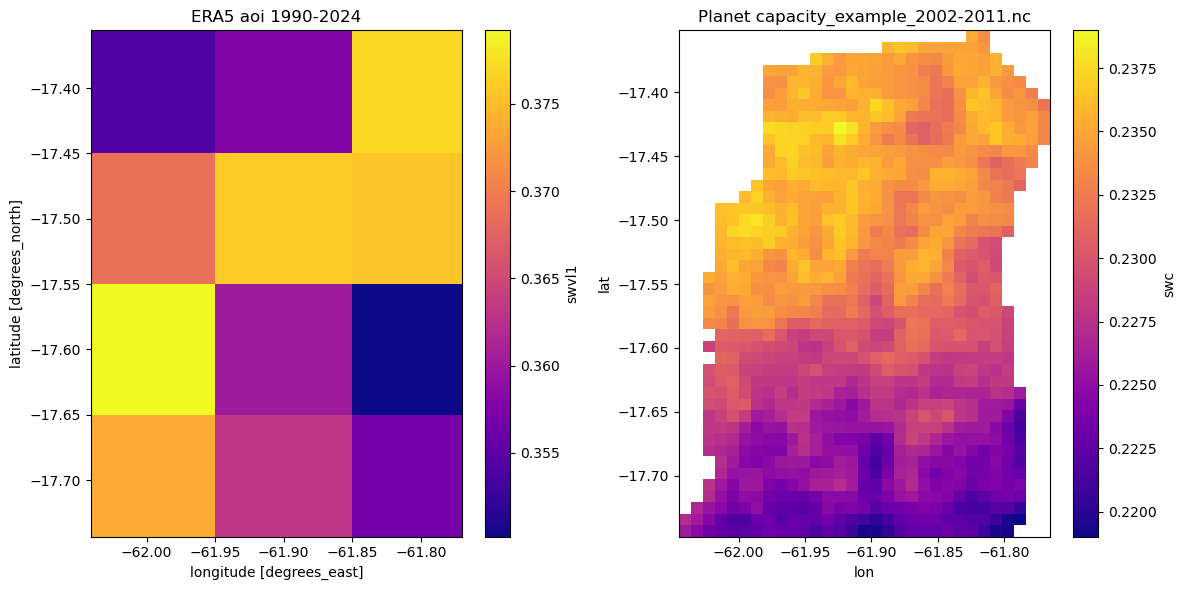

In [10]:
var1_cropped = var1.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

var1_cropped.mean(dim='time').plot(ax=axes[0], cmap='plasma')
axes[0].set_title("ERA5 aoi 1990-2024")
axes[0].set_xlim(lon_min, lon_max)
axes[0].set_ylim(lat_min, lat_max)

var2.mean(dim='time').plot(ax=axes[1], cmap='plasma')
axes[1].set_title("Planet " + ifile)

plt.tight_layout()



### 2. time series

In [11]:
# select one specific pixel of era5 data

lon_pixel_target = var1_cropped.longitude.values[1]  # Primer valor de longitud
lat_pixel_target = var1_cropped.latitude.values[2]   # Primer valor de latitud
delta_grid = 0.1

In [12]:
lon_pixel_target, lat_pixel_target

(-61.9, -17.6)

In [13]:
time_series_var1 = var1.sel(longitude=lon_pixel_target, latitude=lat_pixel_target)

In [14]:
lon_slice = slice(lon_pixel_target - delta_grid/2, lon_pixel_target + delta_grid/2)
lat_slice = slice(lat_pixel_target + delta_grid/2, lat_pixel_target - delta_grid/2)

time_series_var2 = var2.sel(lon=lon_slice, lat=lat_slice)

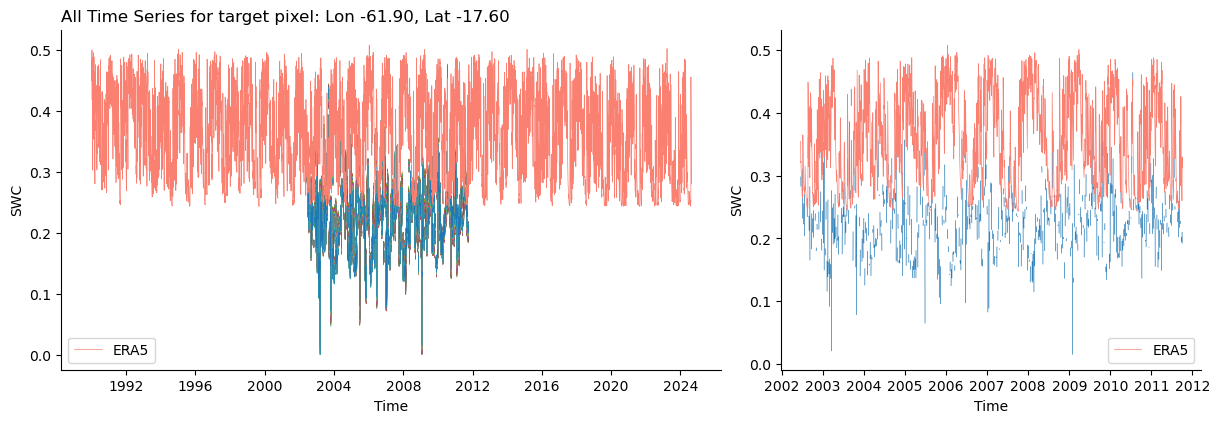

In [15]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.axes([0.05, 0.05, 0.55, 0.85])
for lat in time_series_var2.lat:
    for lon in time_series_var2.lon:
        series = time_series_var2.sel(lat=lat, lon=lon)
        ax1.plot(series.time, series, lw=0.5)

ax1.set_title(f"All Time Series for target pixel: Lon {lon_pixel_target:.2f}, Lat {lat_pixel_target:.2f}", loc='left')
ax1.set_xlabel("Time")
ax1.set_ylabel("SWC")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

series = time_series_var1
ax1.plot(series.time, series, lw=0.5, color='salmon', label='ERA5')
ax1.legend();


ax2 = plt.axes([0.65, 0.05, 0.35, 0.85])
series = time_series_var2.mean(dim=('lat', 'lon'))
ax2.plot(series.time, series, lw=0.5)

time_min = series.time.min().values
time_max = series.time.max().values

series = time_series_var1.sel(time=slice(time_min, time_max))
ax2.plot(series.time, series, lw=0.5, color='salmon', label='ERA5')
ax2.legend();

ax2.set_xlabel("Time")
ax2.set_ylabel("SWC")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)





> **Alert:** It may be an offset?

In [16]:
series_var2 = time_series_var2.mean(dim=('lat', 'lon'))

time_min = series.time.min().values
time_max = series.time.max().values

series_var1 = time_series_var1.sel(time=slice(time_min, time_max))


In [17]:
series_var2.shape == series_var1.shape

True

#### trabajemos con las anomalias

In [18]:

climatology_daily_var2 = series_var2.groupby('time.dayofyear').mean(dim='time')
climatology_daily_var1 = series_var1.groupby('time.dayofyear').mean(dim='time')

anomaly_var2 = series_var2.groupby('time.dayofyear') - climatology_daily_var2
anomaly_var1 = series_var1.groupby('time.dayofyear') - climatology_daily_var1


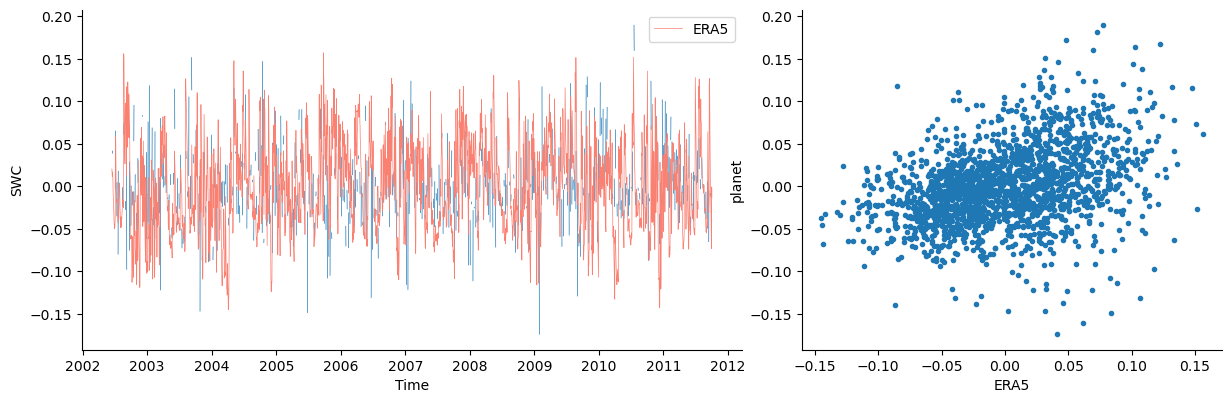

In [19]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.axes([0.05, 0.05, 0.55, 0.85])
ax1.plot(anomaly_var2.time, anomaly_var2, lw=0.5)

ax1.set_xlabel("Time")
ax1.set_ylabel("SWC")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.plot(anomaly_var1.time, anomaly_var1, lw=0.5, color='salmon', label='ERA5')
ax1.legend();

ax2 = plt.axes([0.65, 0.05, 0.35, 0.85])
ax2.plot(anomaly_var1, anomaly_var2, '.')

ax2.set_xlabel("ERA5")
ax2.set_ylabel("planet")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)



In [20]:
# correlation between two timeseries
correlation = xr.corr(anomaly_var1, anomaly_var2, dim="time")
print(f"Temporal correlation: {correlation.values:.2f}")


Temporal correlation: 0.35


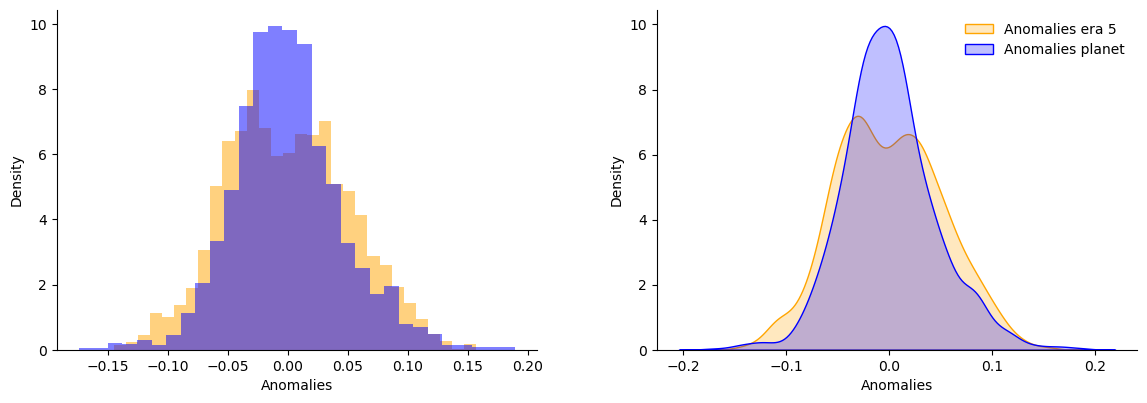

In [21]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.axes([0.05, 0.05, 0.40, 0.85])

ax1.hist(anomaly_var1, bins=30, density=True, alpha=0.5, label="Anomalies era5", color='orange')
ax1.hist(anomaly_var2, bins=30, density=True, alpha=0.5, label="Anomalies planet", color='blue')

ax1.set_xlabel("Anomalies")
ax1.set_ylabel("Density")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.axes([0.55, 0.05, 0.4, 0.85])

sns.kdeplot(anomaly_var1, label="Anomalies era 5", color="orange", fill=True, ax=ax2)
sns.kdeplot(anomaly_var2, label="Anomalies planet", color="blue", fill=True, ax=ax2)

ax2.set_xlabel("Anomalies")
ax2.set_ylabel("Density")
ax2.legend(frameon=False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

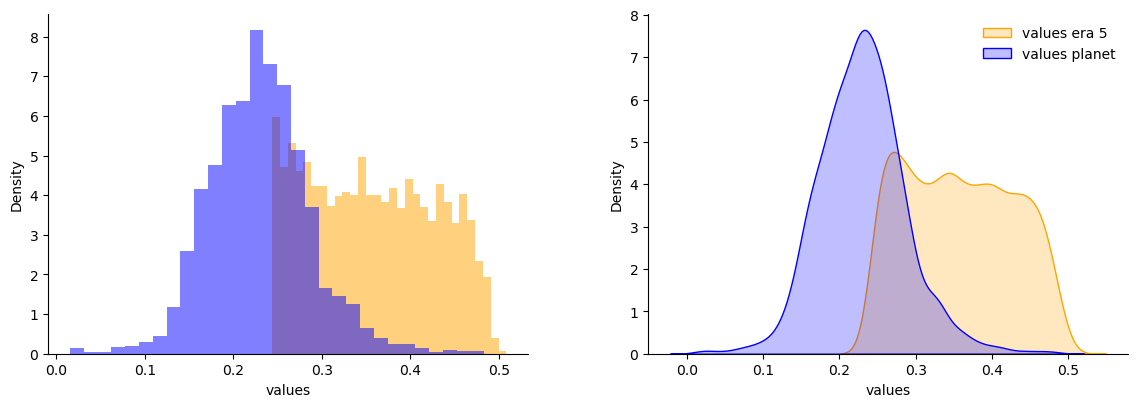

In [22]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.axes([0.05, 0.05, 0.40, 0.85])

ax1.hist(series_var1, bins=30, density=True, alpha=0.5, label="values era5", color='orange')
ax1.hist(series_var2, bins=30, density=True, alpha=0.5, label="values planet", color='blue')

ax1.set_xlabel("values")
ax1.set_ylabel("Density")

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.axes([0.55, 0.05, 0.4, 0.85])

sns.kdeplot(series_var1, label="values era 5", color="orange", fill=True, ax=ax2)
sns.kdeplot(series_var2, label="values planet", color="blue", fill=True, ax=ax2)

ax2.set_xlabel("values")
ax2.set_ylabel("Density")
ax2.legend(frameon=False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

In [23]:
mean1, var1 = series_var1.mean().values, series_var1.var().values
mean2, var2 = series_var2.mean().values, series_var2.var().values

print(f"era5 - Mean: {mean1:.3f}, Variance: {var1:.3f}")
print(f"planet - Mean: {mean2:.3f}, Variance: {var2:.3f}")


era5 - Mean: 0.357, Variance: 0.005
planet - Mean: 0.230, Variance: 0.003


In [24]:
## por que esta tan sesgado a los valores mayores a 0.3?